# MNIST 手写数字

参考Kaggle的练习实现

目标：
1. 设计一个层数 $\geq 2$ 的神经网络（NN、MLP），处理识别 minist 手写数字图片。 $ \mathbb{R}^{n} \to \{0, 1, \ldots, 9\}$ 
2. 50k训练数据，图片大小 28x28 像素， 表示 0 ~ 9 的手写数字。 10k验证数据； 10k测试数据
3. 测试数据上accuracy至少95%，满分需要达到 98%以上。 画出 train loss和test loss曲线

## 0. import

In [7]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.cm as cm
import matplotlib.pyplot as plt

import keras


Using TensorFlow backend.


## 1. 数据预处理

In [8]:

(X_train_orig, y_train_orig), (X_test_orig, y_test_orig) = keras.datasets.mnist.load_data()

# X_train, y_train, X_val, y_val, X_test, y_test = load_dataset()
print(X_train_orig.shape, y_train_orig.shape)
print(X_test_orig.shape, y_test_orig.shape)


(60000, 28, 28) (60000,)
(10000, 28, 28) (10000,)


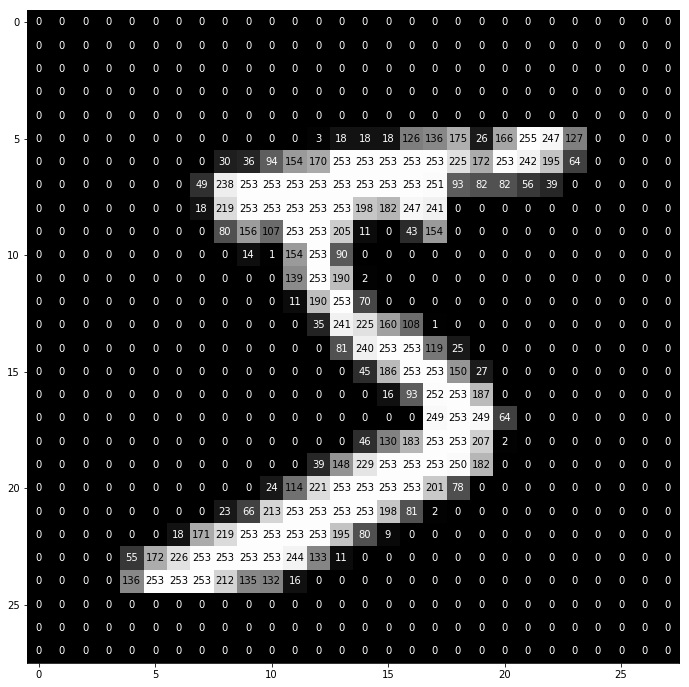

In [9]:
def visualize_input(img, ax):
    ax.imshow(img, cmap='gray')
    width, height = img.shape
    thresh = img.max()/2.5
    for x in range(width):
        for y in range(height):
            ax.annotate(str(round(img[x][y],2)), xy=(y,x),
                        horizontalalignment='center',
                        verticalalignment='center',
                        color='white' if img[x][y]<thresh else 'black')

fig = plt.figure(figsize = (12,12)) 
ax = fig.add_subplot(111)
visualize_input(X_train_orig[0], ax)

In [10]:

# normalize x
X_train = X_train_orig.astype(float) / 255.
X_test = X_test_orig.astype(float) / 255.

# we reserve the last 10000 training examples for validation
X_train, X_val = X_train_orig[:-10000], X_train_orig[-10000:]
y_train, y_val, y_test = y_train_orig[:-10000], y_train_orig[-10000:], y_test_orig

# reshape flatten
X_train = X_train.reshape([X_train.shape[0], -1])
X_val = X_val.reshape([X_val.shape[0], -1])
X_test = X_test.reshape([X_test.shape[0], -1])


# one-hot encoding labels

from keras.utils import np_utils

# lables - one hot encoding
y_train = np_utils.to_categorical(y_train)
y_val = np_utils.to_categorical(y_val)
y_test = np_utils.to_categorical(y_test)

print(y_train[0])

[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


## 2. Keras Model - MLP

主要思想：

1. 2层MLP足以表现映射函数，不添加正则化手段，可以使训练集上的准确度到100%。但是测试集上的准确度，由于过拟合的原因，相对较低。
2. 两种策略可以提高测试集的准确度：
    1. 增加训练集（ Data augmentation）
    2. 正则化

主要使用正则化的方式


实验记录：

1. (512, tanh, dropout=0) (256, tanh, dropout=0) ，训练 （150， 128）,  准确率： (0.99+, 0.9797)

在训练集上过拟合，测试集误差提升不了了。

2. (512, relu, dropout=0) (256, relu, dropout=0)， 训练 （50， 128）， 准确率会非常差 0.09... 与初始化条件有关系？

3. (512, tanh, dropout=0.1) (256, tanh, dropout=0)， 加了dropout层， 准去了（0.98+， 0.97）。。 

In [50]:
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout

input_dim = X_train.shape[1]
nb_classes = y_train.shape[1]

# Here's a Deep Dumb MLP (DDMLP)
model = Sequential()
model.add(Dense(512, input_dim=input_dim))
model.add(Activation('tanh'))
model.add(Dropout(0.2))
model.add(Dense(256))
model.add(Activation('tanh'))
model.add(Dropout(0.2))
model.add(Dense(nb_classes))
model.add(Activation('softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 512)               401920    
_________________________________________________________________
activation_1 (Activation)    (None, 512)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
activation_2 (Activation)    (None, 256)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                2570      
__________

In [51]:

from keras.callbacks import ModelCheckpoint   

# train the model
checkpointer = ModelCheckpoint(filepath='mnist.model.best.hdf5', verbose=1, save_best_only=True)

# compile the model
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', 
              metrics=['accuracy'])


In [52]:
score = model.evaluate(X_val, y_val, verbose=0)
accuracy = 100*score[1]

# print test accuracy
print('validation accuracy: %.4f%%' % accuracy)

validation accuracy: 9.8300%


In [53]:

model.fit(X_train, y_train, 
          epochs=100, batch_size=128, 
          validation_data=(X_val, y_val), 
          callbacks=[checkpointer], verbose=1)


Train on 50000 samples, validate on 10000 samples
Epoch 1/100
50000/50000 [==============================] - 1s 15us/step - loss: 0.4627 - acc: 0.8537 - val_loss: 0.2351 - val_acc: 0.9290

Epoch 00001: val_loss improved from inf to 0.23506, saving model to mnist.model.best.hdf5
Epoch 2/100
50000/50000 [==============================] - 2s 34us/step - loss: 0.2853 - acc: 0.9117 - val_loss: 0.1952 - val_acc: 0.9426

Epoch 00002: val_loss improved from 0.23506 to 0.19522, saving model to mnist.model.best.hdf5
Epoch 3/100
50000/50000 [==============================] - 1s 22us/step - loss: 0.2313 - acc: 0.9293 - val_loss: 0.1700 - val_acc: 0.9478

Epoch 00003: val_loss improved from 0.19522 to 0.17001, saving model to mnist.model.best.hdf5
Epoch 4/100
50000/50000 [==============================] - 1s 29us/step - loss: 0.2059 - acc: 0.9359 - val_loss: 0.1566 - val_acc: 0.9529

Epoch 00004: val_loss improved from 0.17001 to 0.15665, saving model to mnist.model.best.hdf5
Epoch 5/100
50000/5000

KeyboardInterrupt: 

In [54]:
model.evaluate(X_test, y_test)

10000/10000 [==============================] - 1s 74us/step


[0.08468634148743004, 0.9723]

## 3. Tensorflow - MLP

实验记录：

### 1. 无正则化

```
n_hidden_1 = 512
n_hidden_2 = 256
learning_rate = 0.0003
epochs = 200
batch_size = 128
dropout_keep_prob = 1.0
```

调试了很久。发现 learning_rate 真是一个关键的参数。 开始都是设置为0.1，怎么都到不了90% 的正确率，有时候还非常低（不到10%）。 后来设置小一点，发现效果提升很明显。。

设置为0.001，无正则化效果：得到结果：
```
Epoch 150, Minibatch Loss = 0.0874, Training/Test Acc = 0.9985 / 0.9754
Epoch 160, Minibatch Loss = 0.0746, Training/Test Acc = 0.9989 / 0.9761
Epoch 170, Minibatch Loss = 0.0225, Training/Test Acc = 0.9995 / 0.9784
Epoch 180, Minibatch Loss = 0.0218, Training/Test Acc = 0.9997 / 0.9790
Epoch 190, Minibatch Loss = 0.0117, Training/Test Acc = 0.9996 / 0.9782
```
纯训练，理论上应该 100%训练集正确率。 然后想办法提升 测试集正确率


### 2. 正则化

```
n_hidden_1 = 512
n_hidden_2 = 256
learning_rate = 0.0001
epochs = 200
batch_size = 128
dropout_keep_prob = 0.7
```

实际上是第三轮。大概 600个 epoch之后，测试集上达到 98%的准确度。
```
Epoch 160, Minibatch Loss = 0.0013, Training/Test Acc = 0.9998 / 0.9802
Epoch 170, Minibatch Loss = 0.0012, Training/Test Acc = 0.9998 / 0.9805
Epoch 180, Minibatch Loss = 0.0011, Training/Test Acc = 0.9998 / 0.9804
Epoch 190, Minibatch Loss = 0.0011, Training/Test Acc = 0.9998 / 0.9794
```

但是感觉上 keep_prob并没有设么效果...`keep_prob=0.6` 训练 600个epoch：
```
Epoch 260, Minibatch Loss = 0.0160, Training/Test Acc = 0.9953 / 0.9752
Epoch 270, Minibatch Loss = 0.0156, Training/Test Acc = 0.9955 / 0.9760
Epoch 280, Minibatch Loss = 0.0152, Training/Test Acc = 0.9956 / 0.9753
Epoch 290, Minibatch Loss = 0.0151, Training/Test Acc = 0.9958 / 0.9762
```

### 3. L2 正则化

参考一个同学的作业。




### 出现的问题

#### 训练的准确度总是很差

1. 确认模型正确
2. 确认learning rate，如果过大，就不容易训练成功。

#### 训练集的准确率在提升， 测试集的准确率反而下降了。。。

1. relu会有这个问题，改成tanh之后问题消失。
2. leaky_relu也有这个问题，不知道具体原因是什么


#### sigmoid 效果不如 tanh

sigmoid
```
Epoch 0, Minibatch Loss = 1.1800, Training/Test Acc = 0.7605 / 0.7467
Epoch 1, Minibatch Loss = 0.7487, Training/Test Acc = 0.8271 / 0.8006
Epoch 20, Minibatch Loss = 0.2106, Training/Test Acc = 0.9368 / 0.7697
Epoch 40, Minibatch Loss = 0.1409, Training/Test Acc = 0.9563 / 0.7315
Epoch 60, Minibatch Loss = 0.1035, Training/Test Acc = 0.9679 / 0.7444
Epoch 80, Minibatch Loss = 0.0791, Training/Test Acc = 0.9756 / 0.7389
Epoch 100, Minibatch Loss = 0.0634, Training/Test Acc = 0.9804 / 0.7558
```
tanh
```
Epoch 0, Minibatch Loss = 0.7980, Training/Test Acc = 0.7371 / 0.7769
Epoch 1, Minibatch Loss = 0.5619, Training/Test Acc = 0.8201 / 0.8419
Epoch 20, Minibatch Loss = 0.2487, Training/Test Acc = 0.9265 / 0.9262
Epoch 40, Minibatch Loss = 0.1826, Training/Test Acc = 0.9449 / 0.9386
Epoch 60, Minibatch Loss = 0.1424, Training/Test Acc = 0.9574 / 0.9474
Epoch 80, Minibatch Loss = 0.1194, Training/Test Acc = 0.9630 / 0.9520
Epoch 100, Minibatch Loss = 0.1011, Training/Test Acc = 0.9691 / 0.9566
```

In [135]:
# Network Parameters
n_input = 784 # MNIST data input (img shape: 28*28)
n_hidden_1 = 512 # 1st layer number of neurons
n_hidden_2 = 256 # 2nd layer number of neurons
n_classes = 10 # MNIST total classes (0-9 digits)


tf.reset_default_graph()
# input, placeholder
X = tf.placeholder("float", [None, n_input])
Y = tf.placeholder("float", [None, n_classes])
keep_prob = tf.placeholder(tf.float32)

# parameters
W1 = tf.(tf.random_normal((n_input, n_hidden_1), stddev=0.1))
b1 = tf.Variable(tf.random_normal((n_hidden_1,), stddev=0.1))
W2 = tf.Variable(tf.random_normal((n_hidden_1, n_hidden_2), stddev=0.1))
b2 = tf.Variable(tf.random_normal((n_hidden_2,), stddev=0.1))
W3 = tf.Variable(tf.random_normal((n_hidden_2, n_classes), stddev=0.1))
b3 = tf.Variable(tf.random_normal((n_classes,), stddev=0.1))

# multi layer perceptron
Z1 = tf.matmul(X, W1) + b1
A1 = tf.nn.dropout(tf.nn.tanh(Z1), keep_prob=keep_prob)
Z2 = tf.matmul(A1, W2) + b2
A2 = tf.nn.dropout(tf.nn.tanh(Z2), keep_prob=keep_prob)
Z3 = tf.matmul(A2, W3) + b3    
A3 = tf.nn.softmax(Z3)

In [136]:
# Parameters
learning_rate = 0.0001

# Define loss and optimizer
cost_function = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=Z3, labels=Y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost_function)

# Evaluate model (with test logits, for dropout to be disabled)
correct_prediction = tf.equal(tf.argmax(Z3, 1), tf.argmax(Y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))


In [137]:
# start TensorFlow session
init = tf.global_variables_initializer()
sess = tf.InteractiveSession()

sess.run(init)

# training parameters
train_size = X_train.shape[0]
epochs = 200
batch_size = 128
dropout_keep_prob = 0.5
display_epoch = 20


# training 
train_loss = []
val_loss = []

In [138]:

# Start training
for epoch in range(epochs):
    perm = np.arange(train_size)
    np.random.shuffle(perm)
    for i in range(0, train_size, batch_size):
        randidx = perm[i:i+batch_size]
        batch_x = X_train[randidx, :]
        batch_y = y_train[randidx, :]
        # Run optimization op (backprop)
        sess.run(optimizer, feed_dict={X: batch_x, Y: batch_y, keep_prob: 0.5})

    if epoch % display_epoch == 0 or epoch == 1:
        loss, acc = sess.run([cost_function, accuracy], feed_dict={X: X_train, Y: y_train, keep_prob: 1.})
        train_loss.append(loss)
        loss2, acc2 = sess.run([cost_function, accuracy], feed_dict={X: X_test, Y: y_test, keep_prob: 1.})
        val_loss.append(loss2)

        print("Epoch " + str(epoch) + ", Minibatch Loss = " + \
              "{:.4f}".format(loss) + ", Training/Test Acc = " + \
              "{:.4f}".format(acc) + " / " + "{:.4f}".format(acc2))

# print("Optimization Finished!")

# # Calculate accuracy for MNIST test images
# print("Testing Accuracy:", \
#     sess.run(accuracy, feed_dict={X: X_test, Y: y_test, keep_prob: 1.}))

Epoch 0, Minibatch Loss = 0.7980, Training/Test Acc = 0.7371 / 0.7769
Epoch 1, Minibatch Loss = 0.5619, Training/Test Acc = 0.8201 / 0.8419
Epoch 20, Minibatch Loss = 0.2487, Training/Test Acc = 0.9265 / 0.9262
Epoch 40, Minibatch Loss = 0.1826, Training/Test Acc = 0.9449 / 0.9386
Epoch 60, Minibatch Loss = 0.1424, Training/Test Acc = 0.9574 / 0.9474
Epoch 80, Minibatch Loss = 0.1194, Training/Test Acc = 0.9630 / 0.9520
Epoch 100, Minibatch Loss = 0.1011, Training/Test Acc = 0.9691 / 0.9566
Epoch 120, Minibatch Loss = 0.0876, Training/Test Acc = 0.9726 / 0.9592
Epoch 140, Minibatch Loss = 0.0779, Training/Test Acc = 0.9761 / 0.9617
Epoch 160, Minibatch Loss = 0.0687, Training/Test Acc = 0.9790 / 0.9639
Epoch 180, Minibatch Loss = 0.0624, Training/Test Acc = 0.9803 / 0.9648


In [139]:

# Calculate accuracy for MNIST test images
print("Testing Accuracy:", \
    sess.run(accuracy, feed_dict={X: X_test, Y: y_test, keep_prob: 1.}))

Testing Accuracy: 0.967


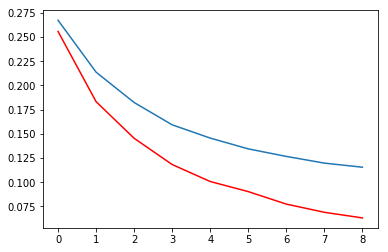

In [114]:
cut = 2
t = np.arange(len(train_loss)-cut)
plt.plot(t, train_loss[cut:], 'r-', t, val_loss[cut:], '-')
plt.show()